# LAB 3 PART 2: Assignment 1

Author: Aliprandi Francesco

## Echo State Network

In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("data/NARMA10.csv", header=None)
X, Y =  torch.tensor(df.iloc[0]),  torch.tensor(df.iloc[1])

X.shape, Y.shape

(torch.Size([10000]), torch.Size([10000]))

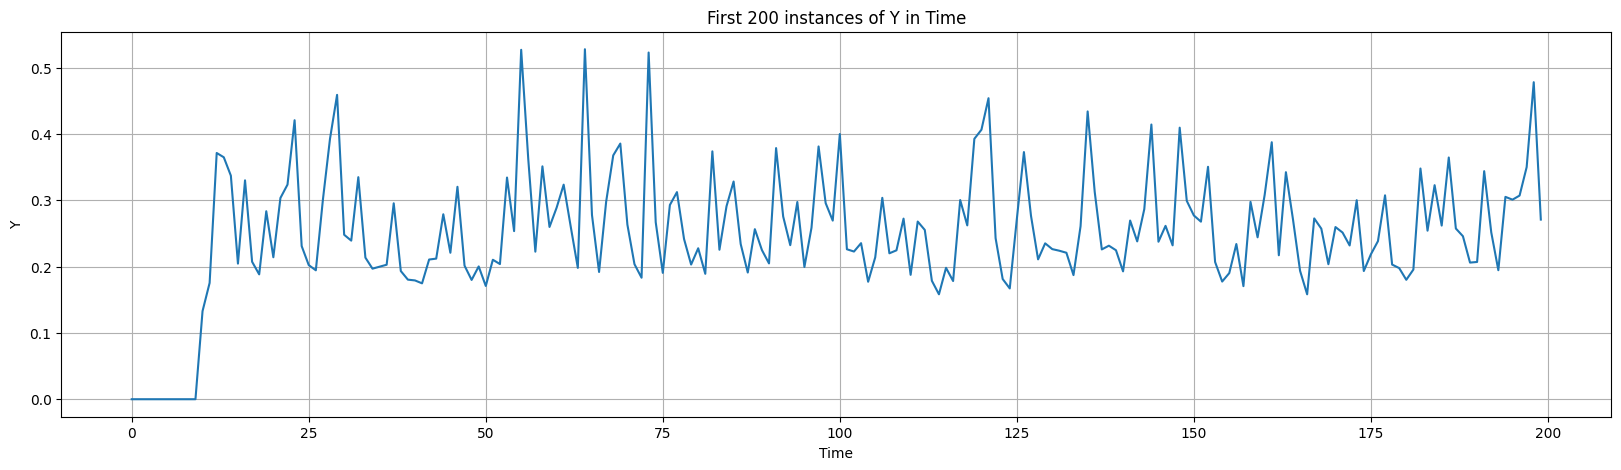

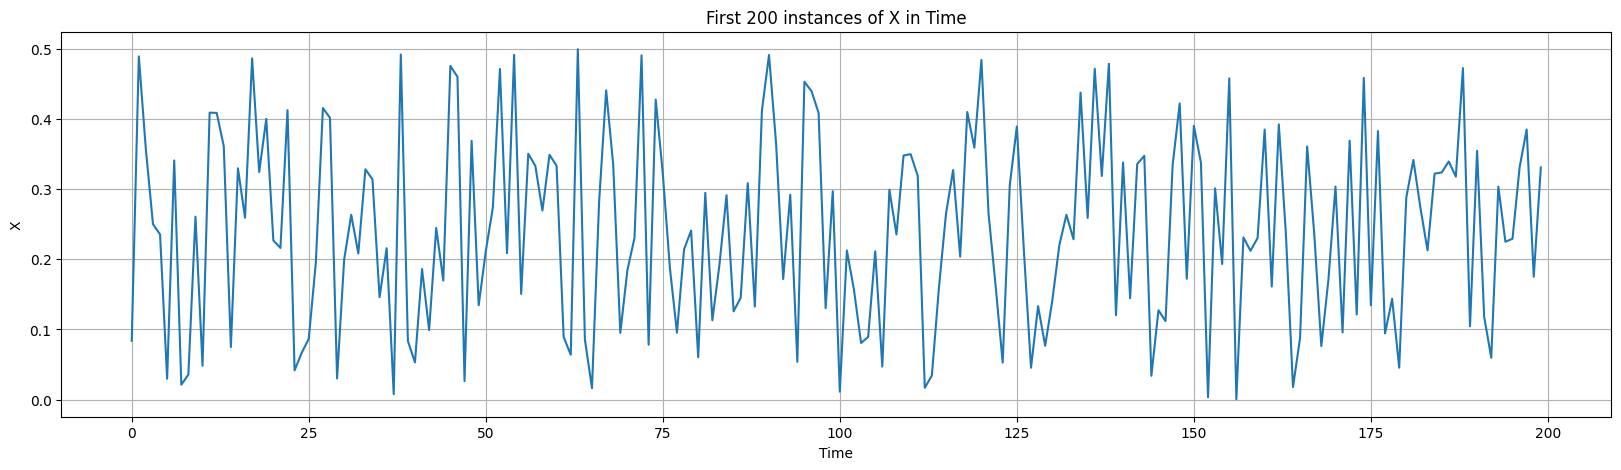

In [2]:
from utils import plot_time_series

time = torch.arange(0, X.shape[0])

plot_time_series(time, Y, "First 200 instances of Y in Time", "Time", "Y", 200)
plot_time_series(time, X, "First 200 instances of X in Time", "Time", "X", 200)
    

### Data Split

In [3]:
from utils import split_data

x_train, x_val, x_test, y_train, y_val, y_test = split_data(X, Y, train_size=4000, val_size=1000)

x_train = x_train.reshape(-1, 1).float()
x_val = x_val.reshape(-1, 1).float()
x_test = x_test.reshape(-1, 1).float()

y_train = y_train.reshape(-1, 1).float()
y_val = y_val.reshape(-1, 1).float()
y_test = y_test.reshape(-1, 1).float()
    
print(f"Training set shape: {x_train.shape}")
print(f"Validation set shape: {x_val.shape}")
print(f"Test set shape: {x_test.shape}")

Training set shape: torch.Size([4000, 1])
Validation set shape: torch.Size([1000, 1])
Test set shape: torch.Size([5000, 1])


In [10]:
from esn import Esn
from utils import plot_predictions
esn = Esn(
    in_dim=1,
    out_dim=1,
    hidden_dim=30,
    rho=0.95,
    omega_in=0.5,
    omega_bias=0.7,
    scaling_type='norm',
    washout = 6
)

h = esn.compute_reservoir(x_train)

y = esn.readout(h)

print(y.shape)
#plot_predictions(y, y_train)


torch.Size([3994, 1])


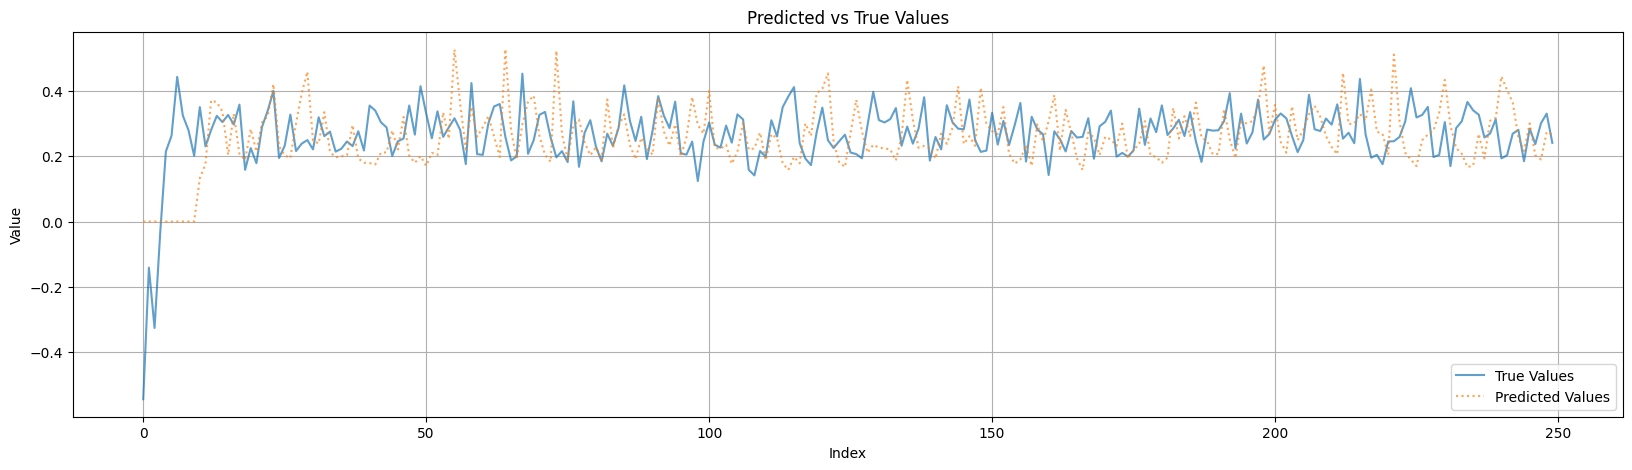

In [11]:
esn.fit(x_train, y_train[6:], 0.001)
y = esn.readout(h)


plot_predictions(y, y_train)

NOTA: MANCA LA SPARSIFICAZIONE DELLA MATRICE HIDDEN